# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Multiple Introduction

In [92]:
import sys
sys.path.append('../../')

In [93]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from ML_Regression import ML_Regression
from util.Save_result_return import save_to_csv

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [95]:
from backtesting import Strategy

## Getting the Data

In [96]:
XAUUSD = load_data()

In [97]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [98]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


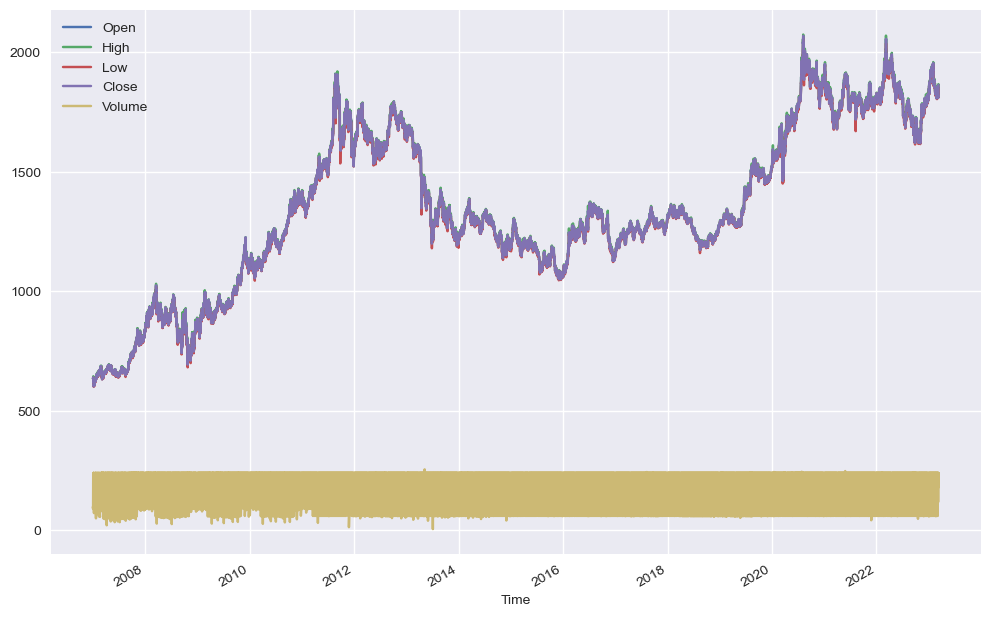

In [99]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [100]:
class Mutiple_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if self.position.is_short:
                self.position.close()
            self.buy(size=1)

        if self.data.pred == -1:
            if self.position.is_long:
                self.position.close()
            self.sell(size=1)

In [101]:
strategy = Mutiple_Regression
account_size = 2000

In [102]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data.dropna(inplace=True)
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=2000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 2000)
        result = backtest.run()
        return result

    def Save_Result(self, df, file_path):

        equity_curve = df['_equity_curve'].copy()
        equity_df = pd.DataFrame(equity_curve, columns=['Equity'])
        equity_df['returns'] = equity_df['Equity'].pct_change().fillna(0)
        equity_df = equity_df.drop('Equity', axis=1)
        equity_df.to_csv(file_path, index=True)

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        filename_train = f'result_{self.TF}_In_Sample.csv'
        filepath_train = f'../../out/Machine_Learning/Multiple_Linear_Regression/Backtest/train.csv'
        # self.Save_Result(result_train, filepath_train)


        self.Predict()
        result_test = self.Backtest(self.data_test)
        filename_test = f'result_{self.TF}_Out_Sample.csv'
        filepath_test = f'../../out/Machine_Learning/Multiple_Linear_Regression/Backtest/test.csv'
        # self.Save_Result(result_test, filepath_test)

        return result_train, result_test

## TF D1

In [103]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'

In [104]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [105]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [106]:
train

Start                     2007-01-08 00:00:00
End                       2020-12-31 00:00:00
Duration                   5106 days 00:00:00
Exposure Time [%]                   72.716843
Equity Final [$]                          0.0
Equity Peak [$]                      8472.644
Return [%]                             -100.0
Buy & Hold Return [%]              211.556943
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]     2066810153812177...
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -3.830112
Max. Drawdown Duration     3202 days 00:00:00
Avg. Drawdown Duration       57 days 00:00:00
# Trades                                 3156
Win Rate [%]                        53.675539
Best Trade [%]                       11.06966
Worst Trade [%]                    -11.684486
Avg. Trade [%]                    

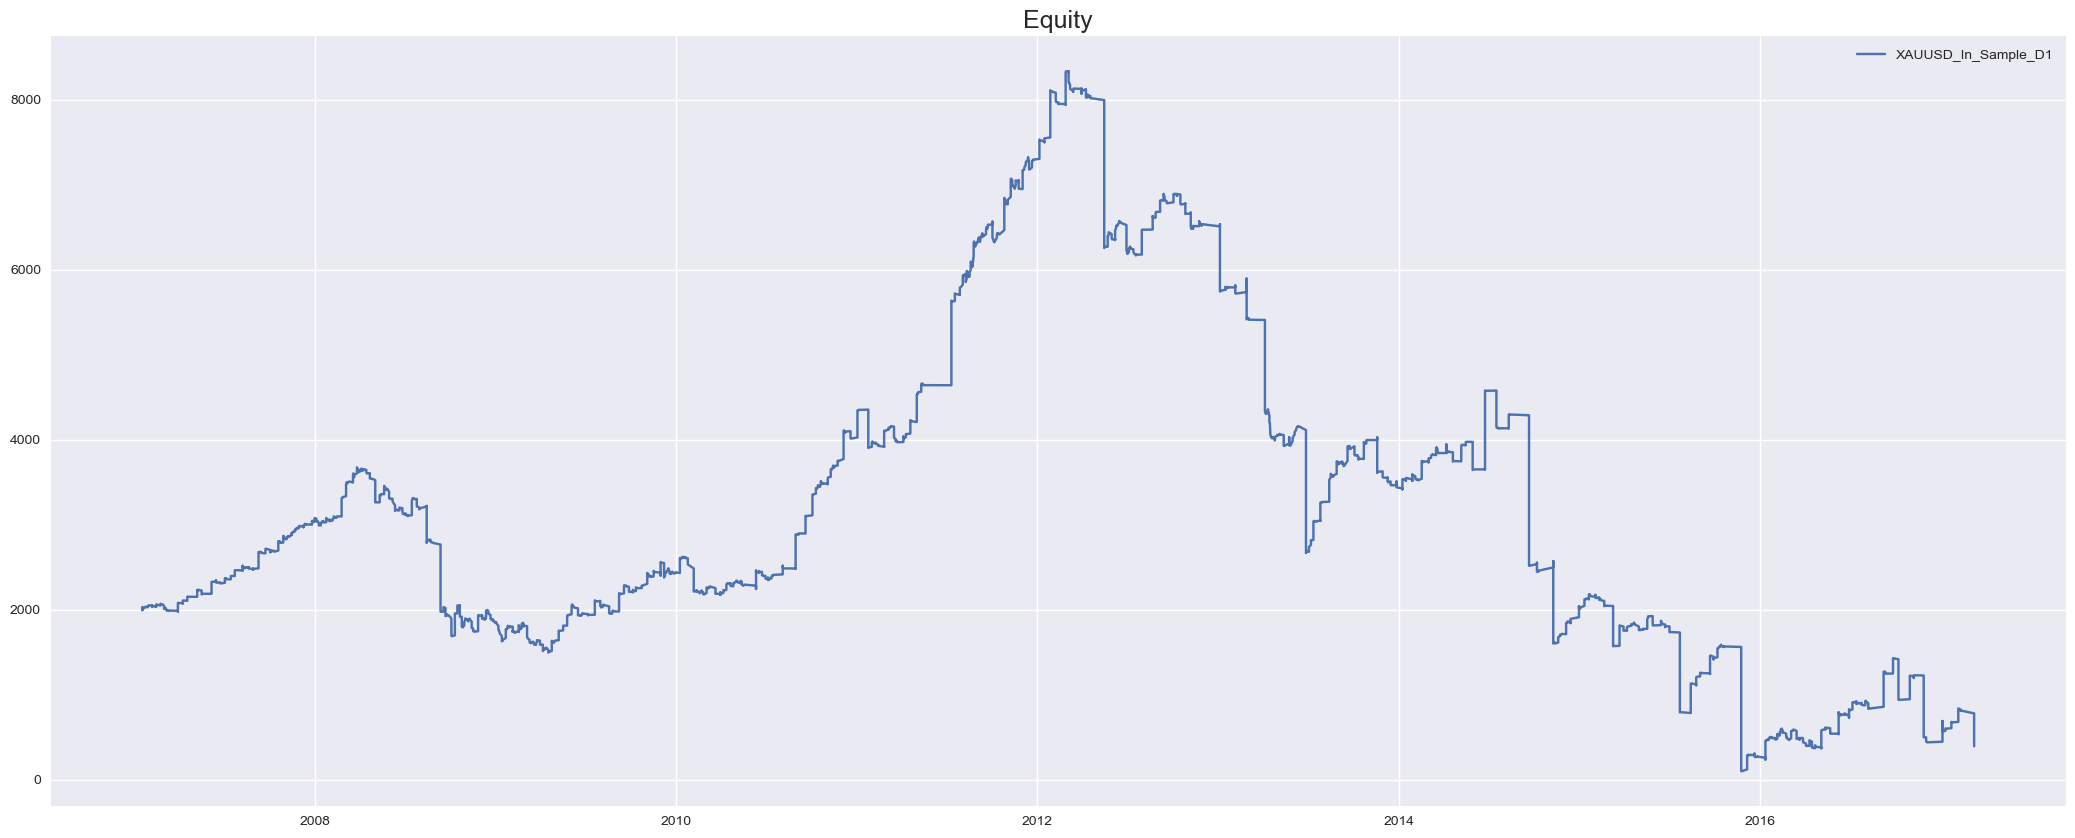

In [107]:
plot_equity_trades(train['_trades'], f'XAUUSD_In_Sample_{TF}' , account_size)

### Out-Sample Backtesting

In [108]:
test

Start                     2020-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   1157 days 00:00:00
Exposure Time [%]                   99.796954
Equity Final [$]                     1522.975
Equity Peak [$]                      6217.581
Return [%]                          -23.85125
Buy & Hold Return [%]               19.648007
Return (Ann.) [%]                   -6.733669
Volatility (Ann.) [%]               62.268916
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -83.636337
Avg. Drawdown [%]                   -5.584669
Max. Drawdown Duration      369 days 00:00:00
Avg. Drawdown Duration       28 days 00:00:00
# Trades                                  983
Win Rate [%]                        53.713123
Best Trade [%]                       9.300688
Worst Trade [%]                      -7.76521
Avg. Trade [%]                    

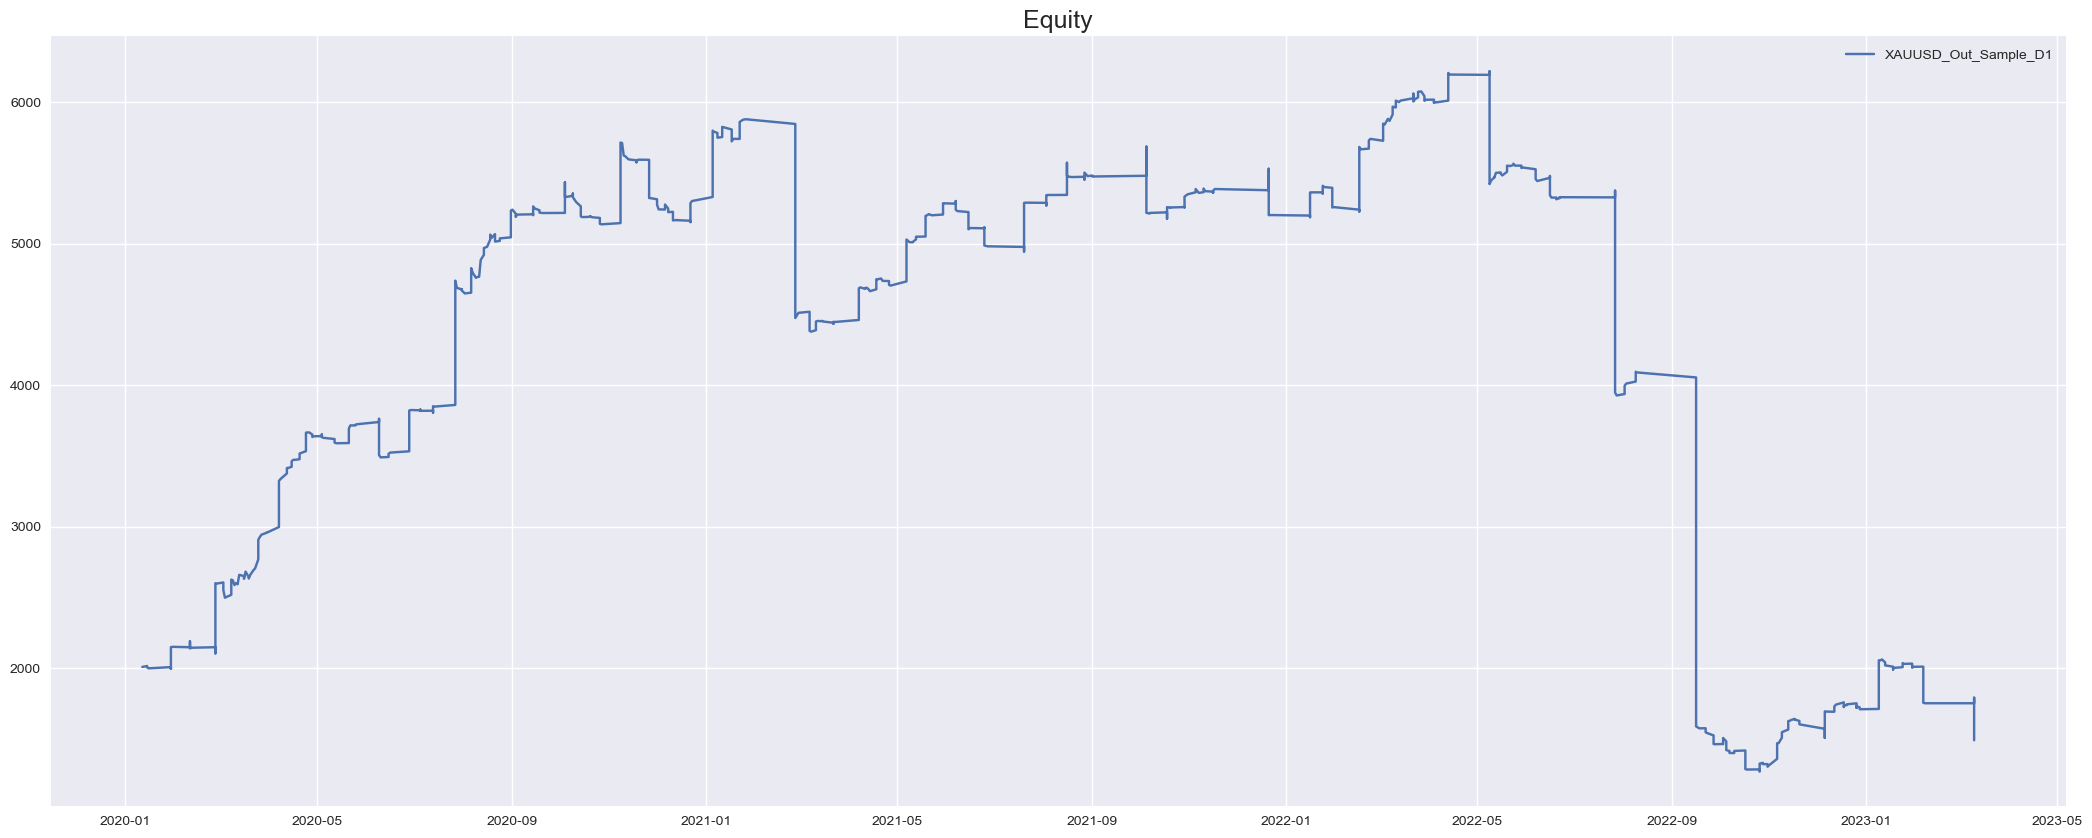

In [109]:
plot_equity_trades(test['_trades'], f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [110]:
filename_train = f'result_{TF}_In_Sample.csv'

In [111]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [112]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [113]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H4

In [114]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'

In [115]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [116]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [117]:
train

Start                     2007-01-02 00:00:00
End                       2020-12-31 20:00:00
Duration                   5112 days 20:00:00
Exposure Time [%]                   55.627754
Equity Final [$]                          0.0
Equity Peak [$]                      3134.651
Return [%]                             -100.0
Buy & Hold Return [%]              197.773172
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]               78.235252
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                    -3.84402
Max. Drawdown Duration     3871 days 20:00:00
Avg. Drawdown Duration       77 days 04:00:00
# Trades                                12498
Win Rate [%]                         49.06385
Best Trade [%]                       7.563357
Worst Trade [%]                     -7.421416
Avg. Trade [%]                    

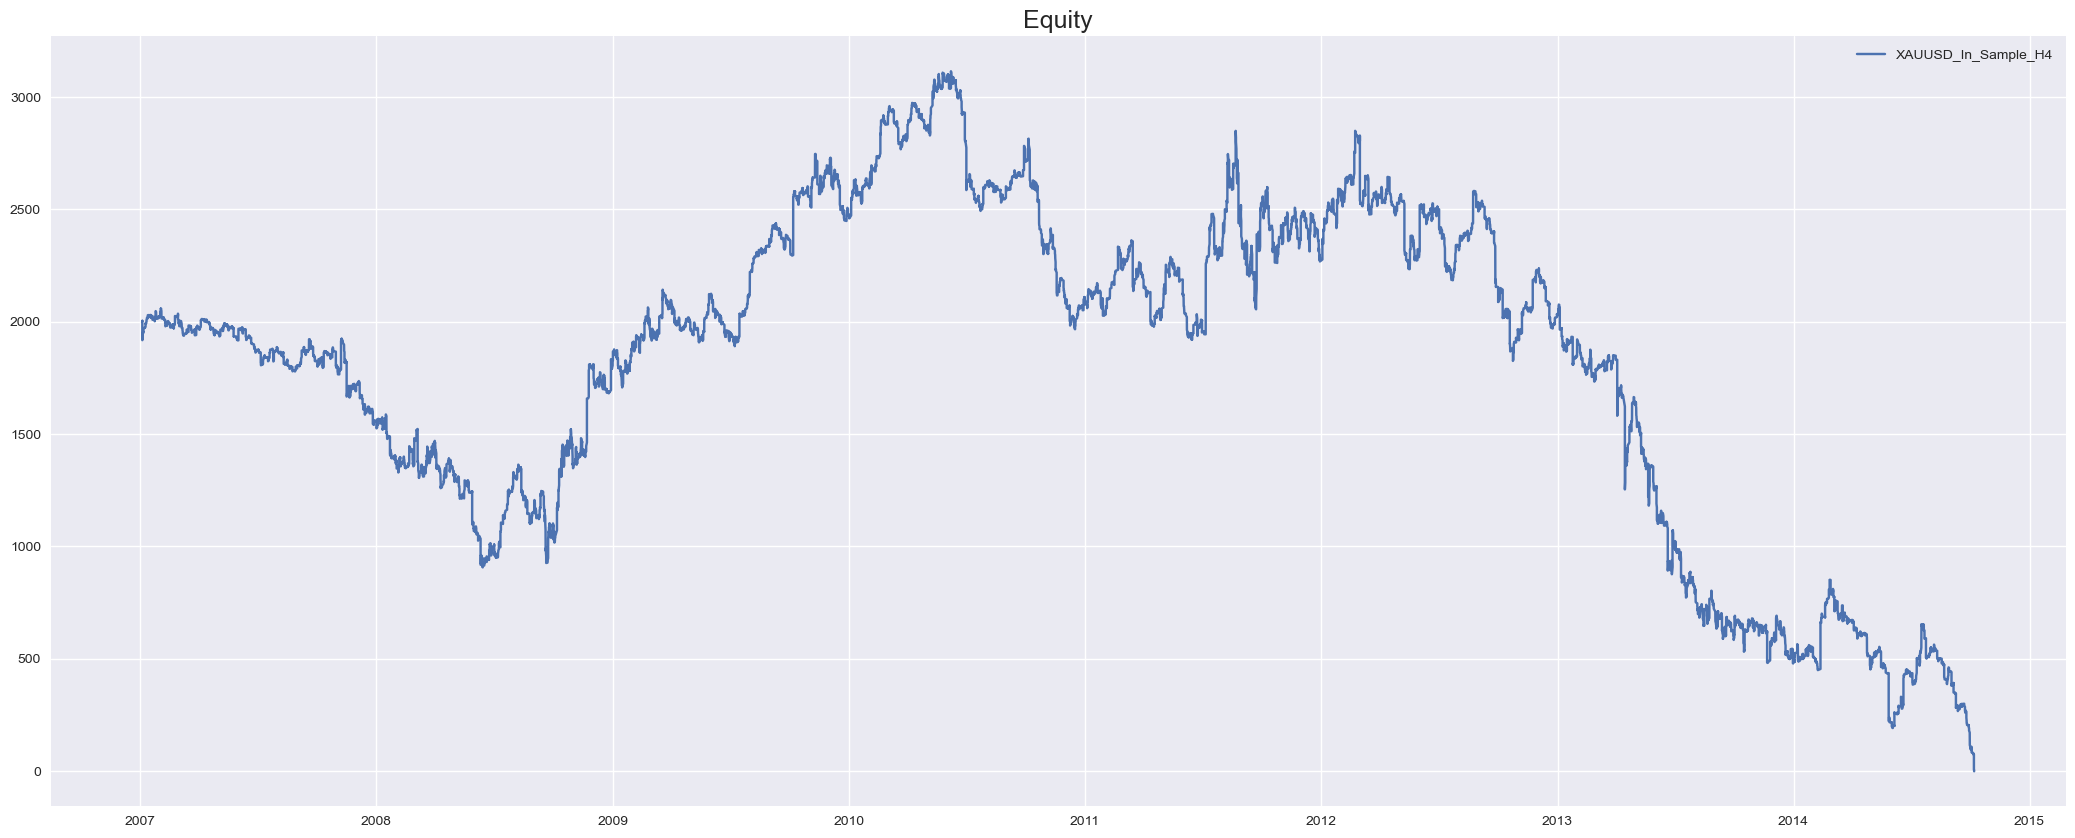

In [118]:
plot_equity_trades(train['_trades'], f'XAUUSD_In_Sample_{TF}' , account_size)

### Out-Sample Backtesting

In [119]:
test

Start                     2020-01-02 20:00:00
End                       2023-03-10 16:00:00
Duration                   1162 days 20:00:00
Exposure Time [%]                   99.960777
Equity Final [$]                       1910.5
Equity Peak [$]                      3334.659
Return [%]                             -4.475
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                   -1.158601
Volatility (Ann.) [%]               38.086812
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -58.379732
Avg. Drawdown [%]                   -4.158618
Max. Drawdown Duration      947 days 16:00:00
Avg. Drawdown Duration       36 days 02:00:00
# Trades                                 5097
Win Rate [%]                        51.873651
Best Trade [%]                        4.16845
Worst Trade [%]                     -5.873167
Avg. Trade [%]                    

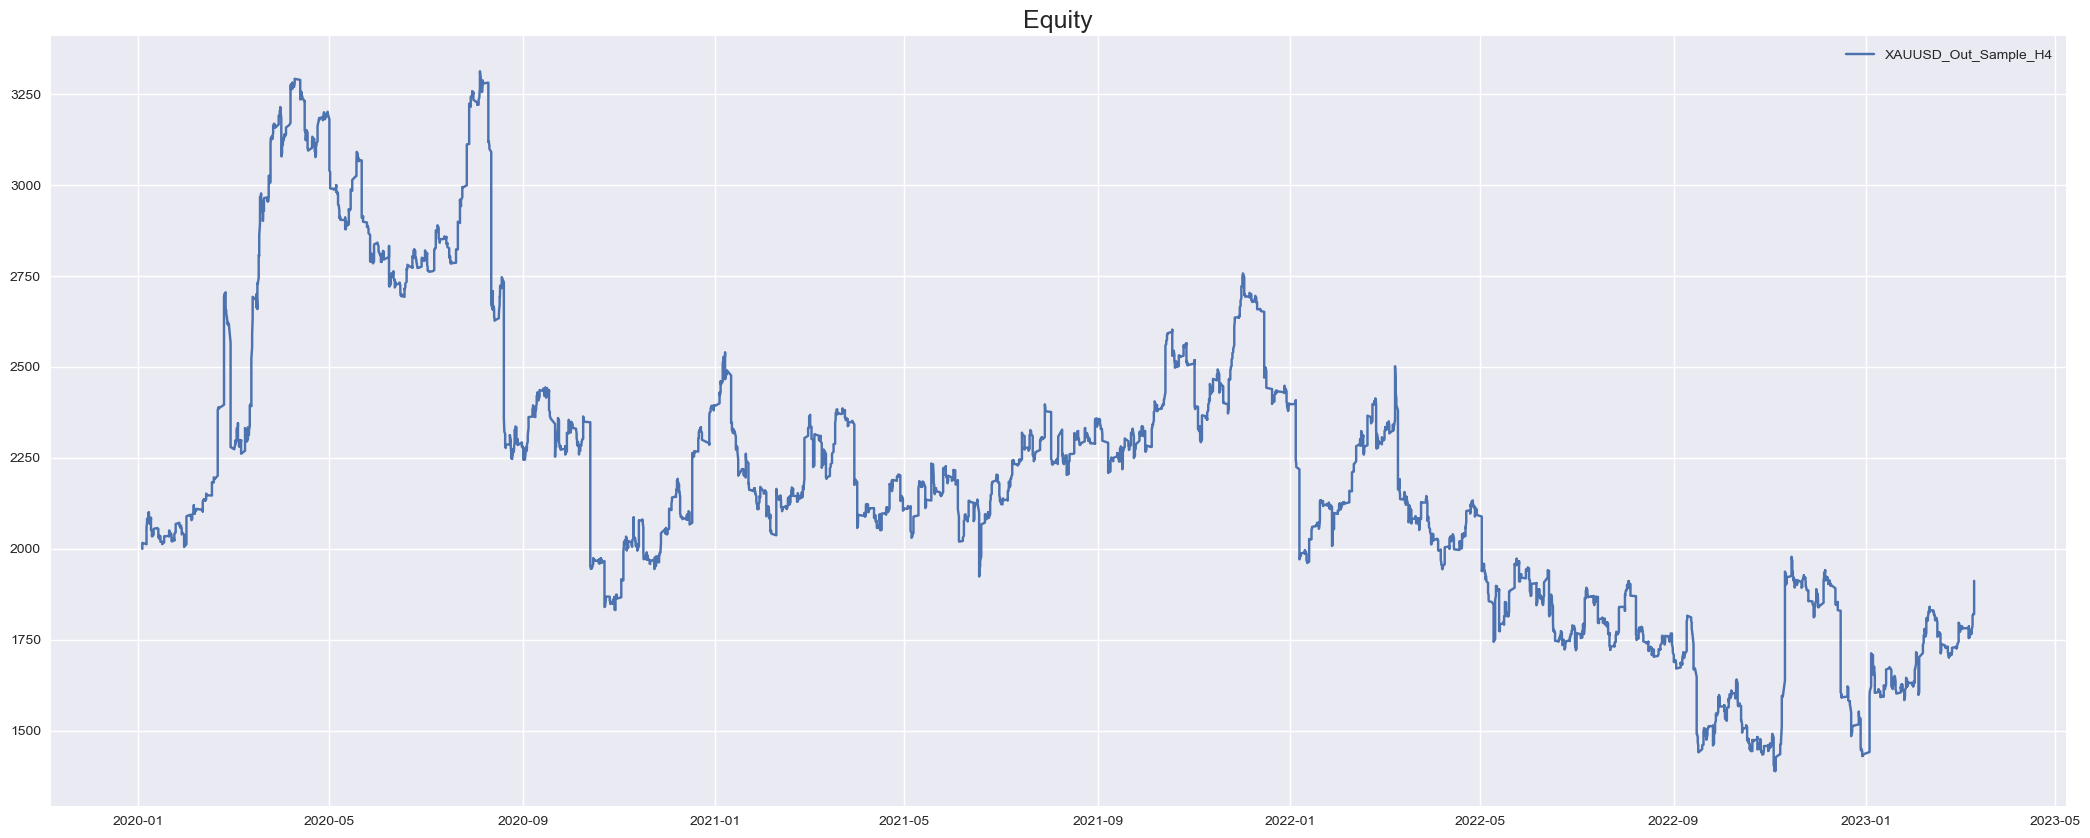

In [120]:
plot_equity_trades(test['_trades'], f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [121]:
filename_train = f'result_{TF}_In_Sample.csv'

In [122]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [123]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [124]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H1

In [125]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'

In [126]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [127]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [128]:
train

Start                     2007-01-01 06:00:00
End                       2020-12-31 21:00:00
Duration                   5113 days 15:00:00
Exposure Time [%]                   53.875381
Equity Final [$]                          0.0
Equity Peak [$]                      8366.234
Return [%]                             -100.0
Buy & Hold Return [%]              198.538115
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              126.627375
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                    -1.56832
Max. Drawdown Duration     3229 days 07:00:00
Avg. Drawdown Duration       14 days 06:00:00
# Trades                                45789
Win Rate [%]                        54.447575
Best Trade [%]                        6.43067
Worst Trade [%]                     -6.950814
Avg. Trade [%]                    

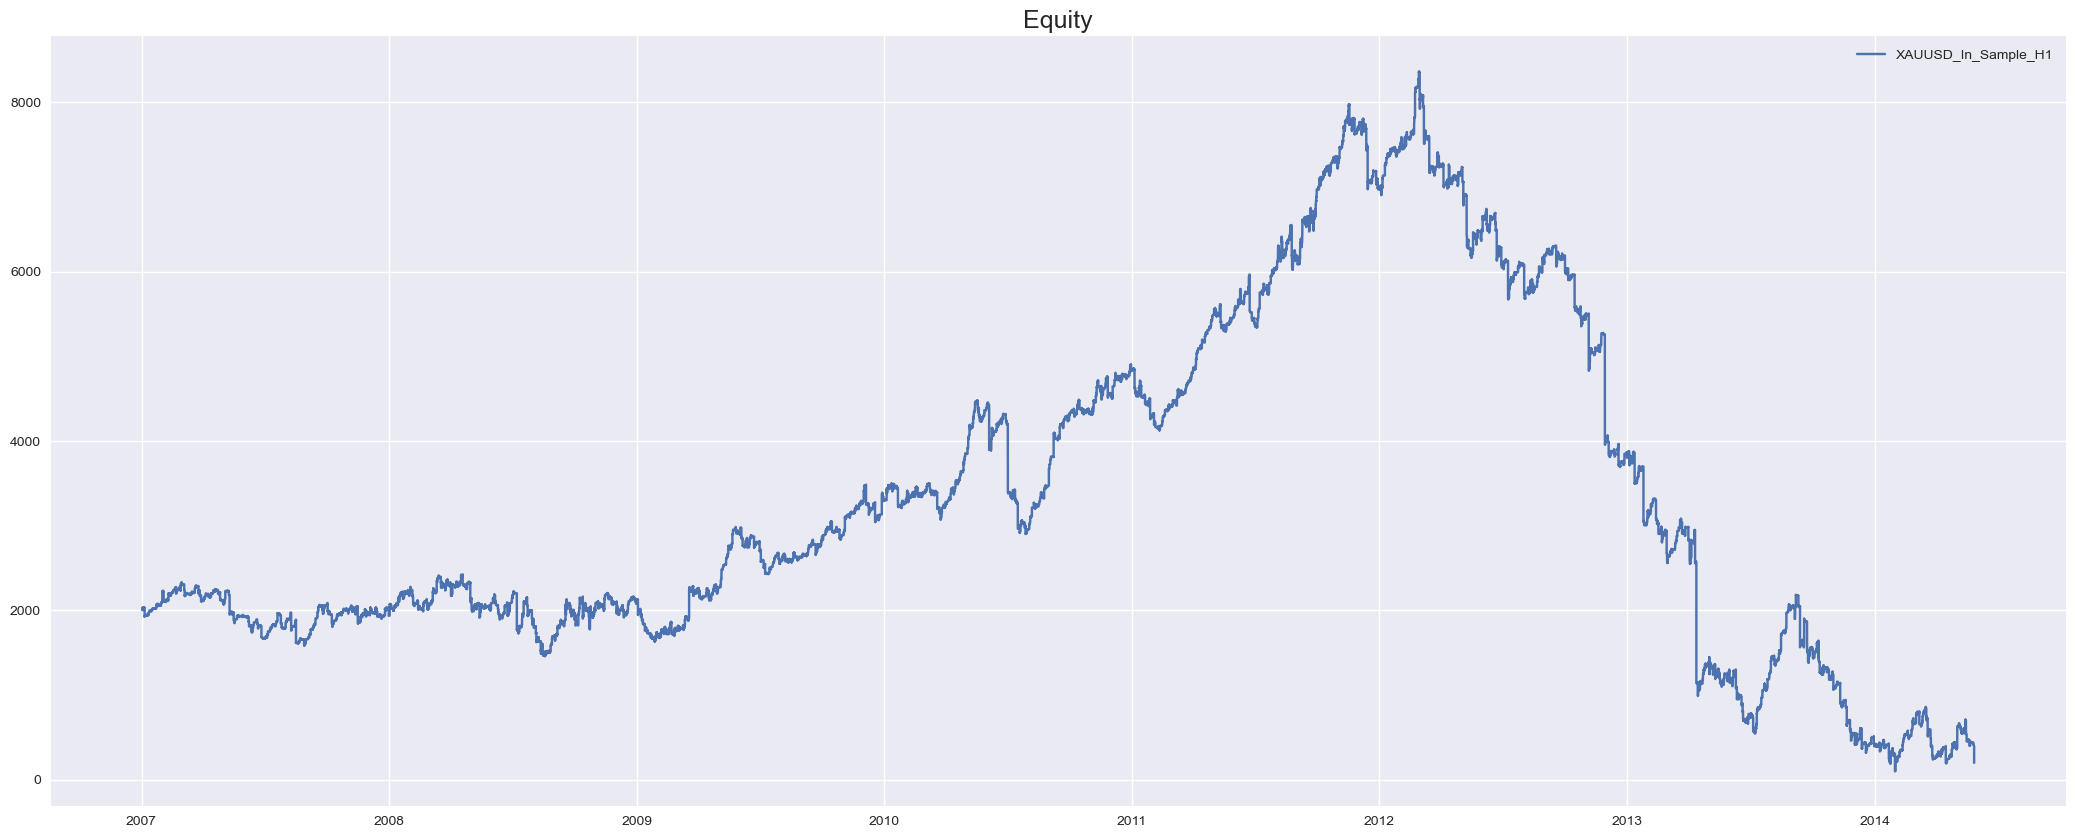

In [129]:
plot_equity_trades(train['_trades'], f'XAUUSD_In_Sample_{TF}' , account_size)

### Out-Sample Backtesting

In [130]:
test

Start                     2020-01-02 05:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   53.561012
Equity Final [$]                          0.0
Equity Peak [$]                       3166.79
Return [%]                             -100.0
Buy & Hold Return [%]               22.623102
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              392.395932
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -5.581626
Max. Drawdown Duration      948 days 02:00:00
Avg. Drawdown Duration       29 days 00:00:00
# Trades                                10080
Win Rate [%]                        54.702381
Best Trade [%]                       4.575548
Worst Trade [%]                     -6.474645
Avg. Trade [%]                    

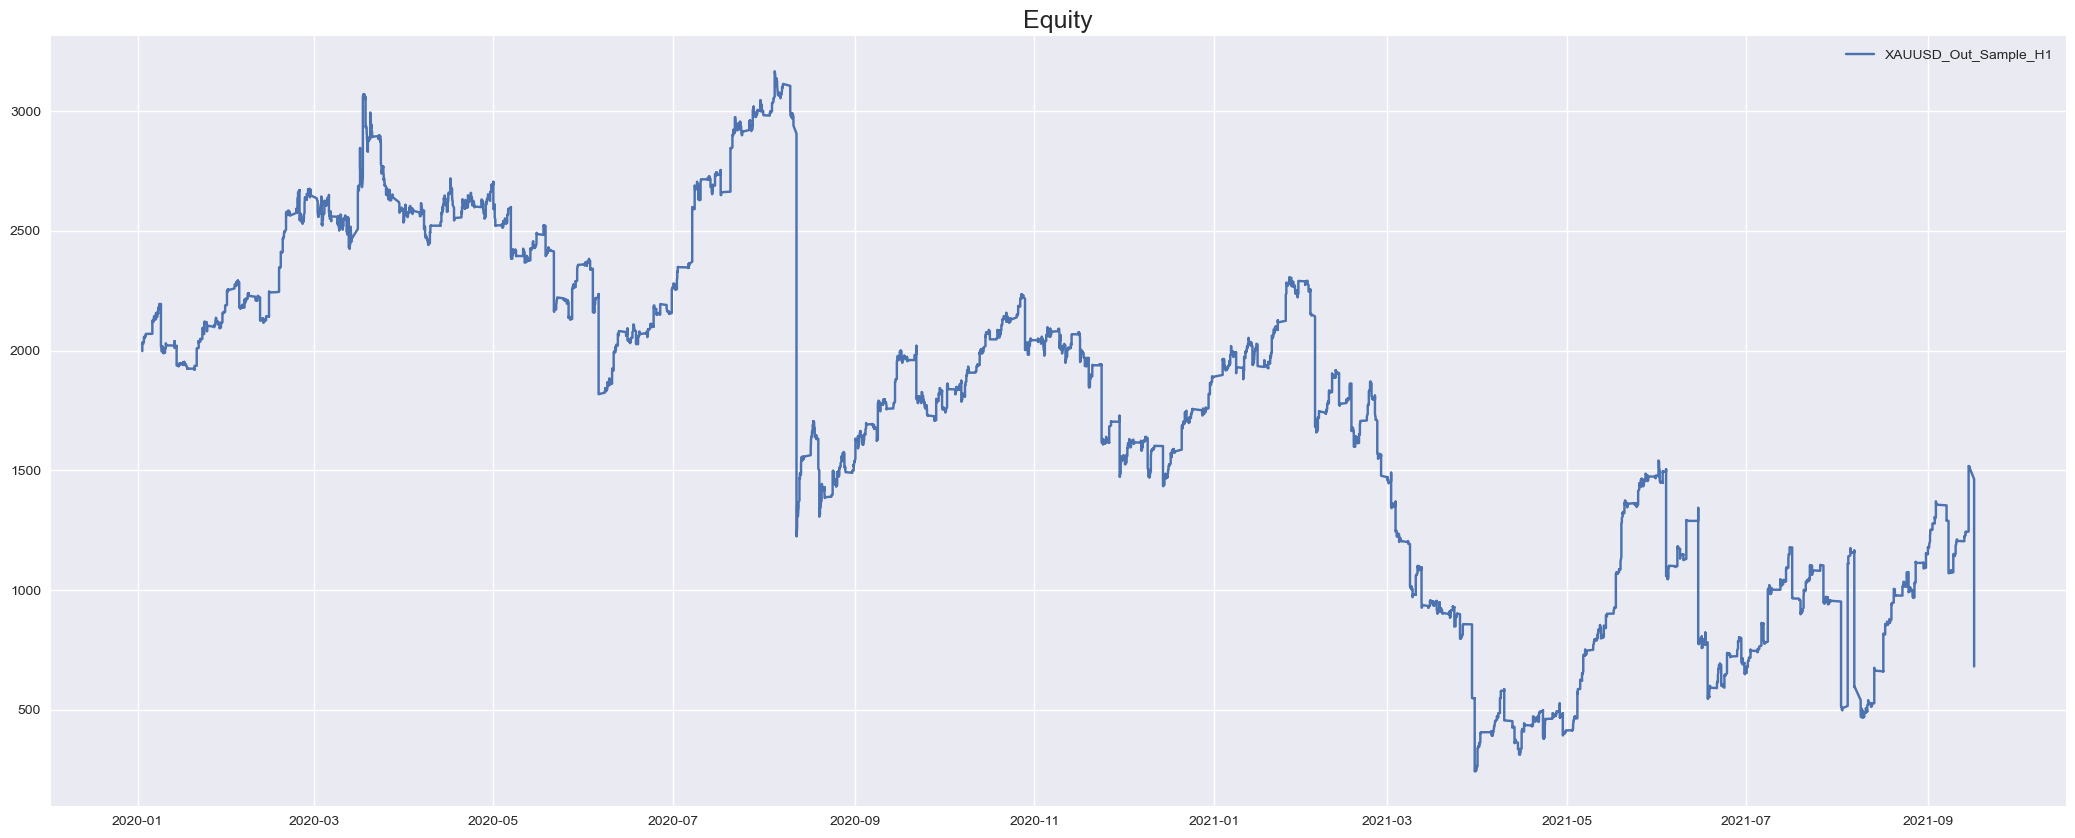

In [131]:
plot_equity_trades(test['_trades'], f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [132]:
filename_train = f'result_{TF}_In_Sample.csv'

In [133]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [134]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [135]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M30

In [136]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'

In [137]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [138]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [139]:
train

Start                     2007-01-01 03:00:00
End                       2020-12-31 21:30:00
Duration                   5113 days 18:30:00
Exposure Time [%]                   99.998819
Equity Final [$]                     11561.22
Equity Peak [$]                     12583.369
Return [%]                            478.061
Buy & Hold Return [%]              198.631601
Return (Ann.) [%]                   10.677574
Volatility (Ann.) [%]               19.076892
Sharpe Ratio                         0.559712
Sortino Ratio                        0.811002
Calmar Ratio                         0.193443
Max. Drawdown [%]                  -55.197432
Avg. Drawdown [%]                   -0.576747
Max. Drawdown Duration     2736 days 00:30:00
Avg. Drawdown Duration        5 days 03:42:00
# Trades                               169365
Win Rate [%]                        55.436483
Best Trade [%]                       4.383939
Worst Trade [%]                     -4.759791
Avg. Trade [%]                    

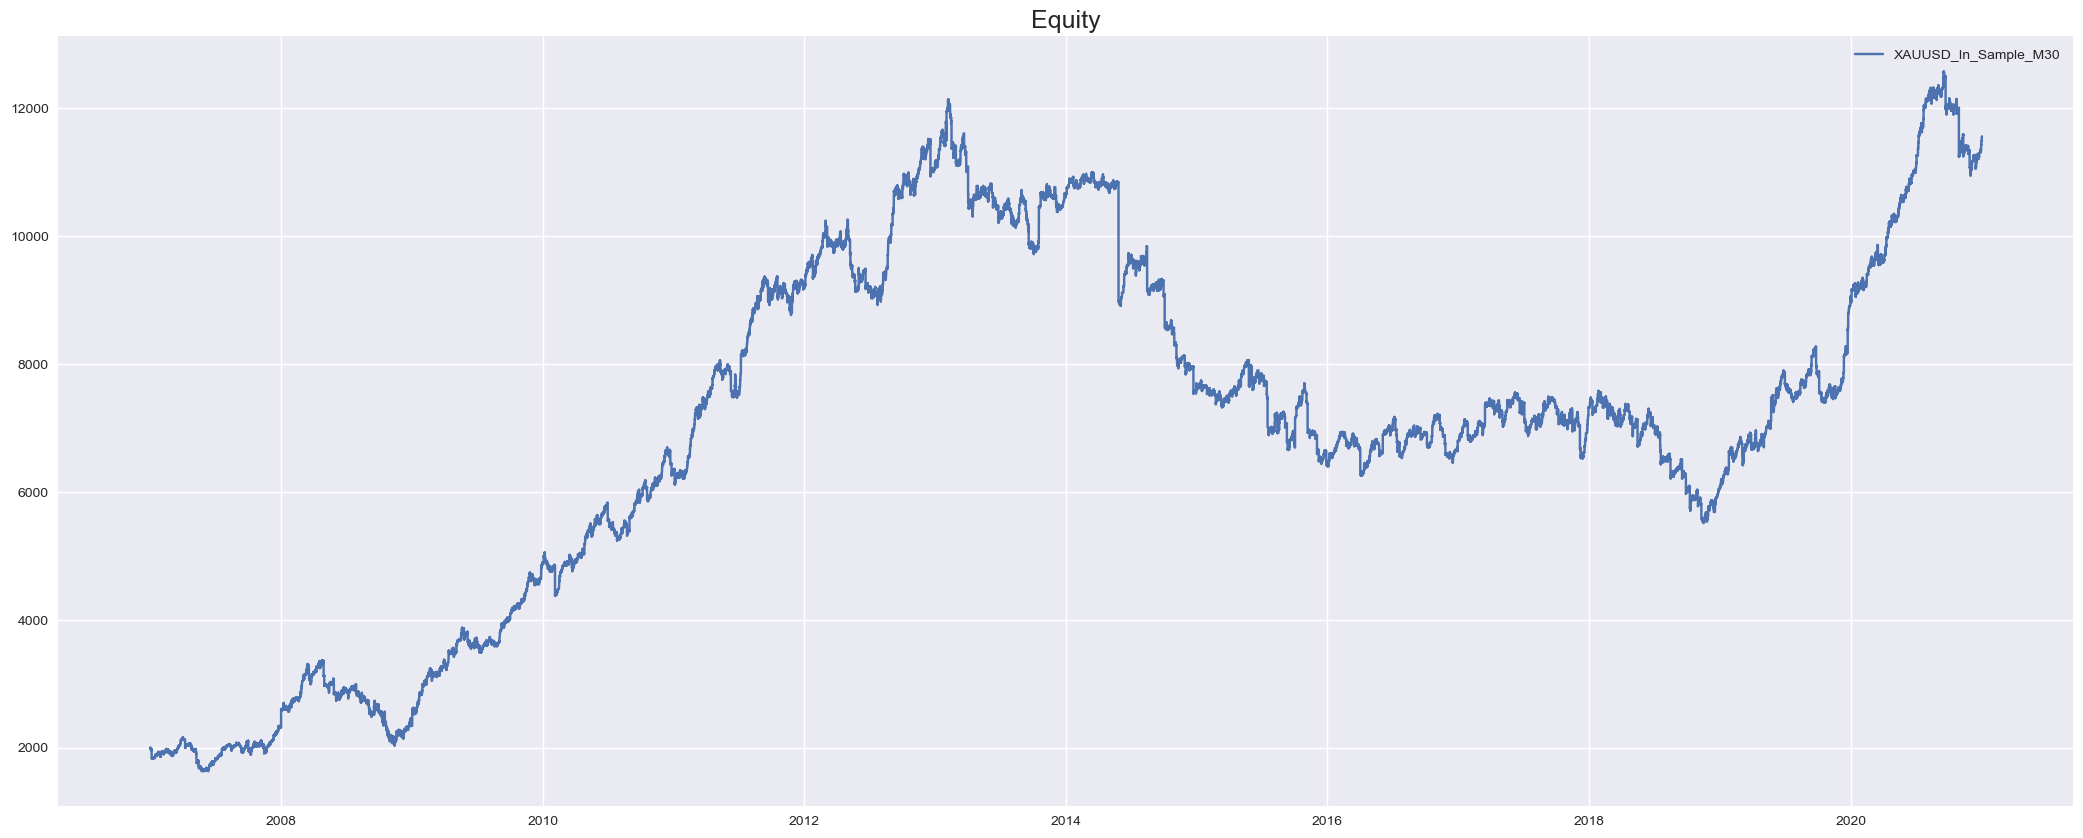

In [140]:
plot_equity_trades(train['_trades'], f'XAUUSD_In_Sample_{TF}' , account_size)

### Out-Sample Backtesting

In [141]:
test

Start                     2020-01-02 02:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 15:30:00
Exposure Time [%]                   99.994696
Equity Final [$]                     7756.868
Equity Peak [$]                      8372.828
Return [%]                           287.8434
Buy & Hold Return [%]                22.67717
Return (Ann.) [%]                   40.473092
Volatility (Ann.) [%]               37.125511
Sharpe Ratio                         1.090169
Sortino Ratio                        2.073701
Calmar Ratio                         1.023526
Max. Drawdown [%]                  -39.542812
Avg. Drawdown [%]                   -0.760151
Max. Drawdown Duration      522 days 05:00:00
Avg. Drawdown Duration        2 days 12:19:00
# Trades                                37708
Win Rate [%]                        55.516071
Best Trade [%]                       2.845167
Worst Trade [%]                     -4.759791
Avg. Trade [%]                    

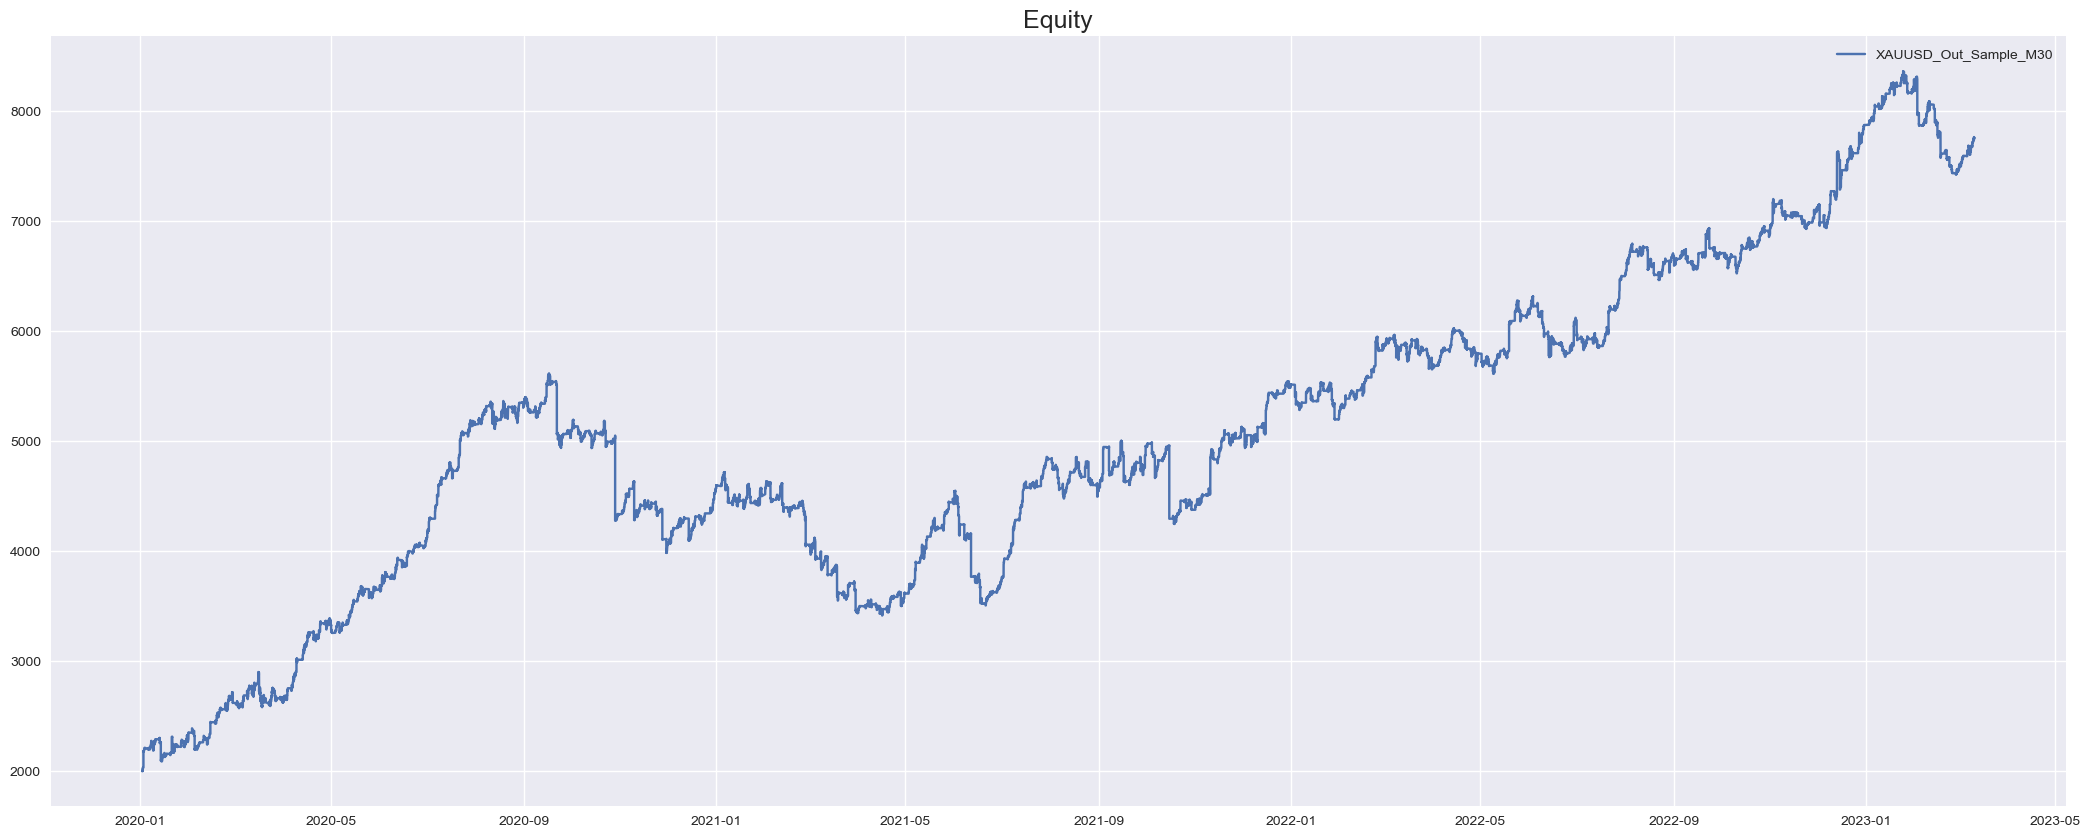

In [142]:
plot_equity_trades(test['_trades'], f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [143]:
filename_train = f'result_{TF}_In_Sample.csv'

In [144]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [145]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [146]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M15

In [147]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'

In [148]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [149]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [150]:
train

Start                     2014-09-23 14:30:00
End                       2020-12-31 21:45:00
Duration                   2291 days 07:15:00
Exposure Time [%]                   99.998651
Equity Final [$]                     3888.431
Equity Peak [$]                      4239.336
Return [%]                           94.42155
Buy & Hold Return [%]                55.35929
Return (Ann.) [%]                    8.907406
Volatility (Ann.) [%]               19.071414
Sharpe Ratio                         0.467055
Sortino Ratio                        0.711185
Calmar Ratio                         0.239344
Max. Drawdown [%]                   -37.21595
Avg. Drawdown [%]                   -0.790352
Max. Drawdown Duration     1327 days 06:30:00
Avg. Drawdown Duration        5 days 08:49:00
# Trades                               148265
Win Rate [%]                        52.839848
Best Trade [%]                       2.481729
Worst Trade [%]                      -2.51628
Avg. Trade [%]                    

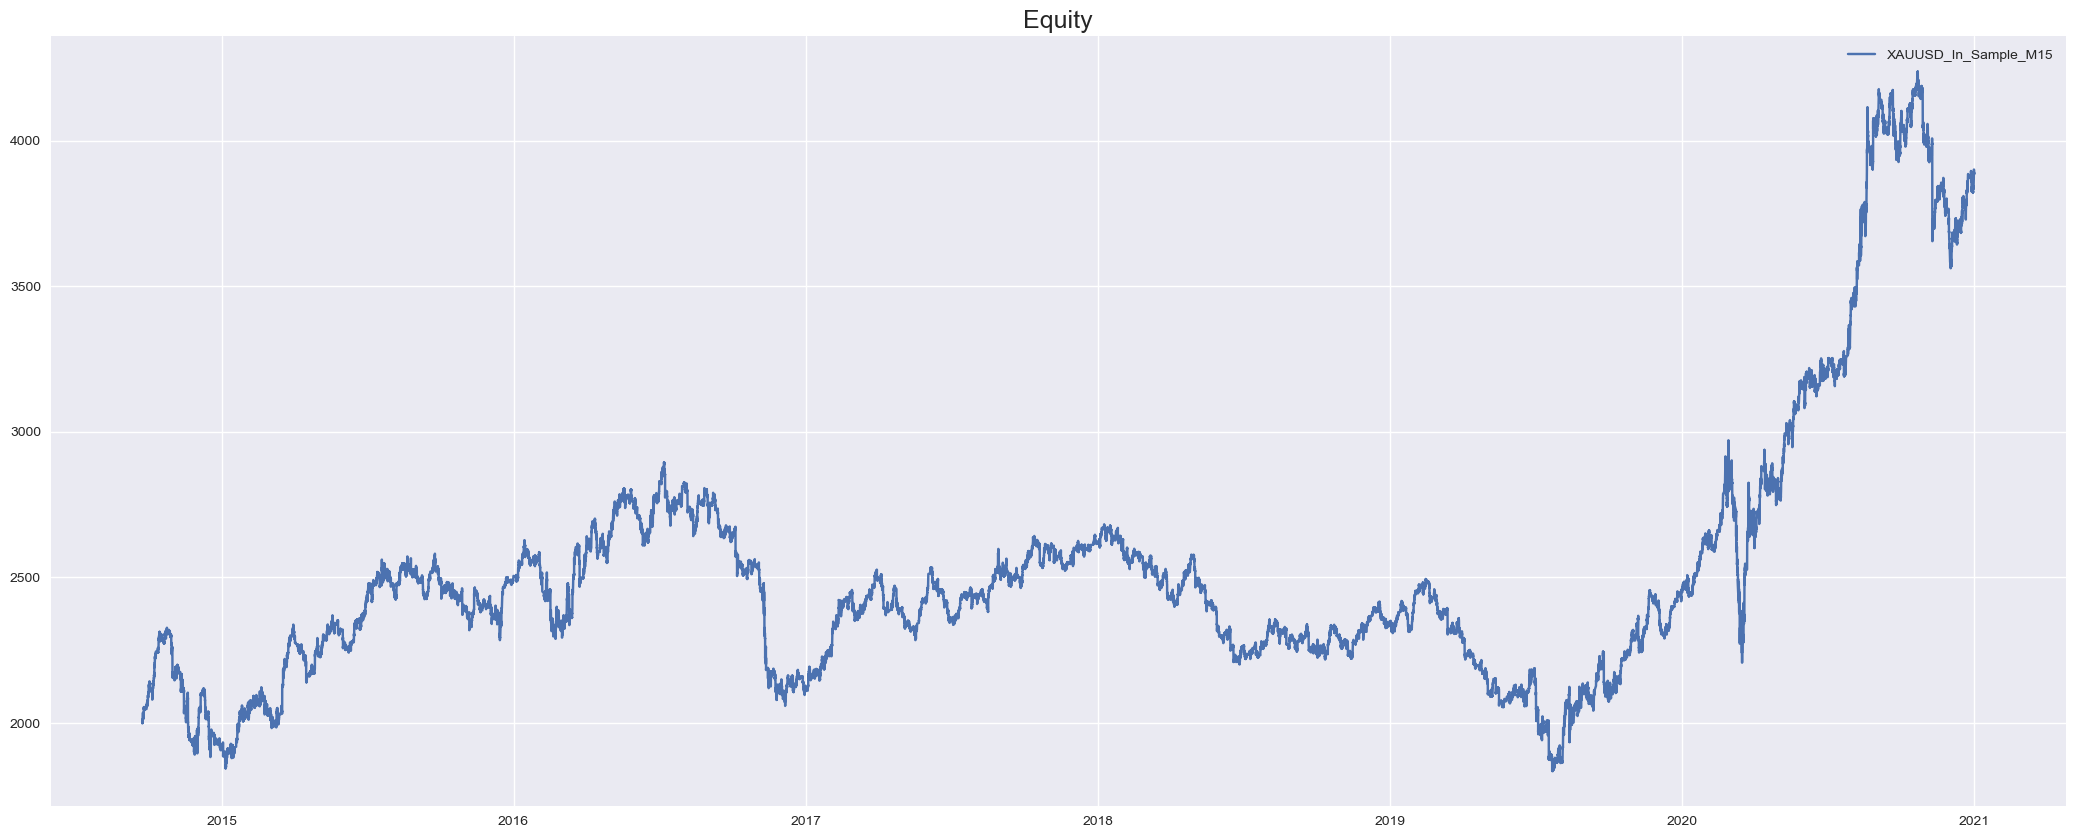

In [151]:
plot_equity_trades(train['_trades'], f'XAUUSD_In_Sample_{TF}' , account_size)

### Out-Sample Backtesting

In [152]:
test

Start                     2020-01-02 00:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 17:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                     4308.471
Equity Peak [$]                      4503.976
Return [%]                          115.42355
Buy & Hold Return [%]               22.768468
Return (Ann.) [%]                   21.276697
Volatility (Ann.) [%]               24.001613
Sharpe Ratio                         0.886469
Sortino Ratio                        1.548015
Calmar Ratio                         0.629681
Max. Drawdown [%]                  -33.789644
Avg. Drawdown [%]                   -0.679563
Max. Drawdown Duration      283 days 19:15:00
Avg. Drawdown Duration        2 days 17:21:00
# Trades                                75421
Win Rate [%]                        52.769123
Best Trade [%]                       1.698484
Worst Trade [%]                     -2.894386
Avg. Trade [%]                    

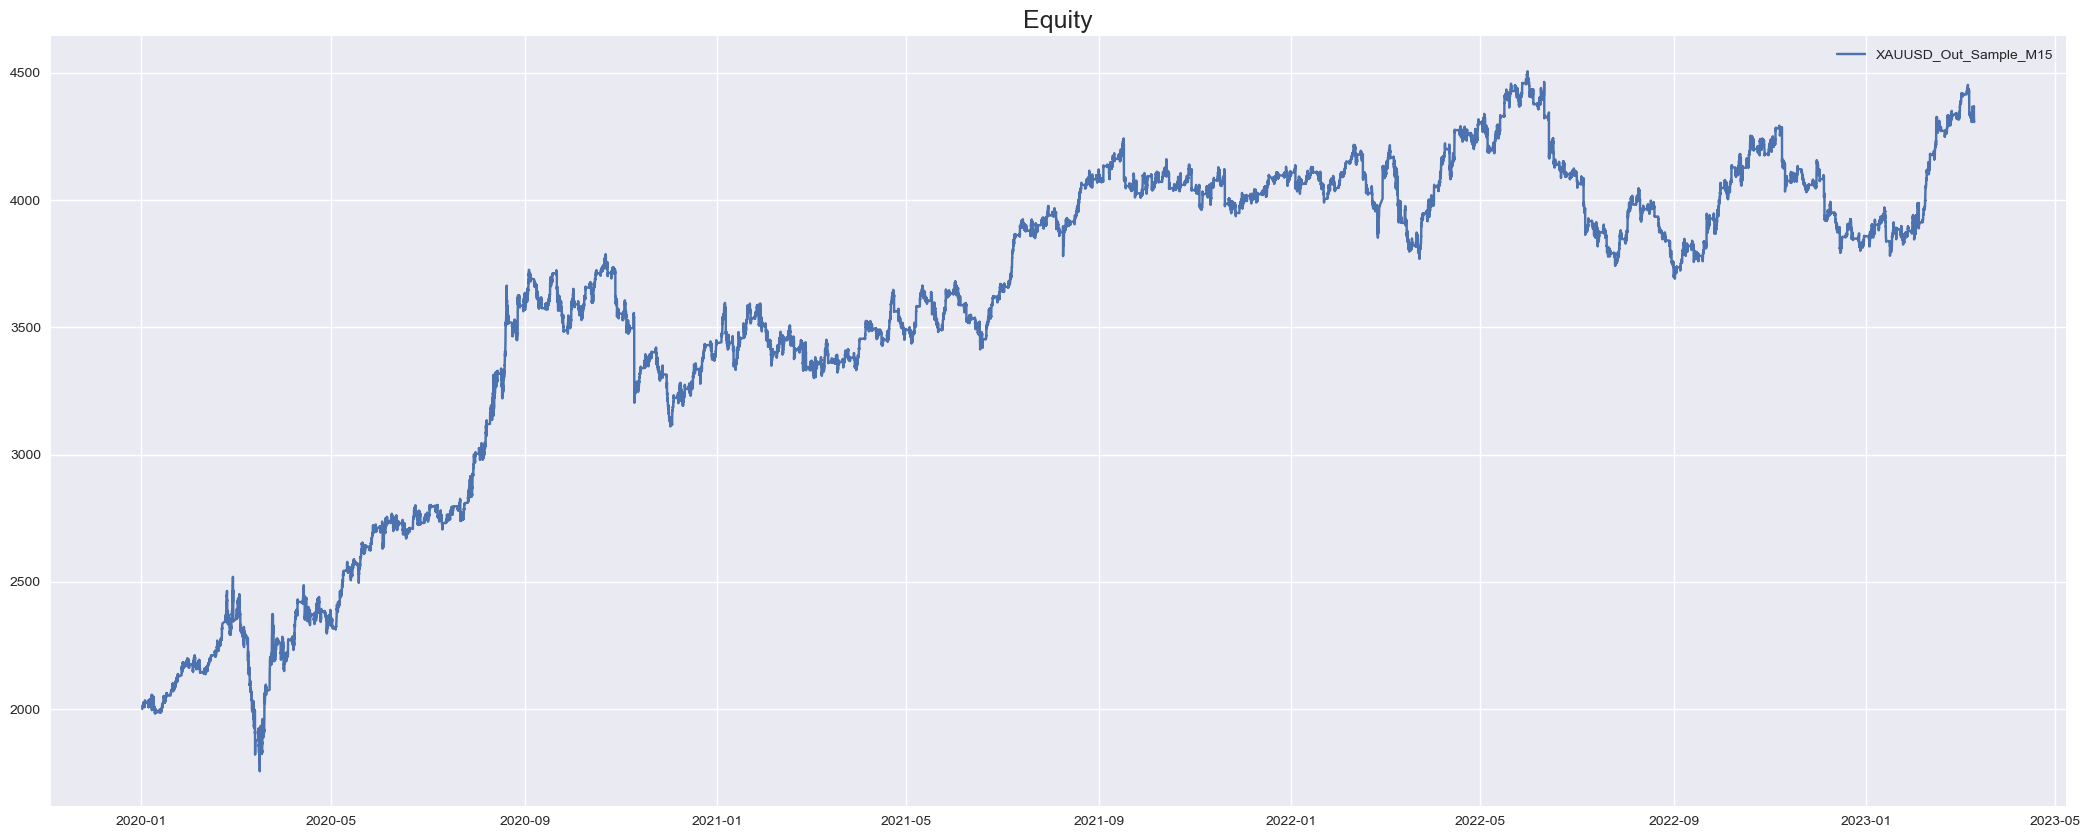

In [153]:
plot_equity_trades(test['_trades'], f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [154]:
filename_train = f'result_{TF}_In_Sample.csv'

In [155]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [156]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [157]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M5

In [158]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'

In [159]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [160]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_18304\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [161]:
train

Start                     2020-05-15 11:40:00
End                       2023-03-10 17:55:00
Duration                   1029 days 06:15:00
Exposure Time [%]                      99.999
Equity Final [$]                     3695.477
Equity Peak [$]                      3775.371
Return [%]                           84.77385
Buy & Hold Return [%]                   7.591
Return (Ann.) [%]                   19.790455
Volatility (Ann.) [%]                23.30422
Sharpe Ratio                         0.849222
Sortino Ratio                        1.372173
Calmar Ratio                         0.833489
Max. Drawdown [%]                  -23.744104
Avg. Drawdown [%]                   -0.392164
Max. Drawdown Duration      274 days 05:00:00
Avg. Drawdown Duration        1 days 12:21:00
# Trades                               199992
Win Rate [%]                        51.863075
Best Trade [%]                       1.030794
Worst Trade [%]                     -3.754972
Avg. Trade [%]                    

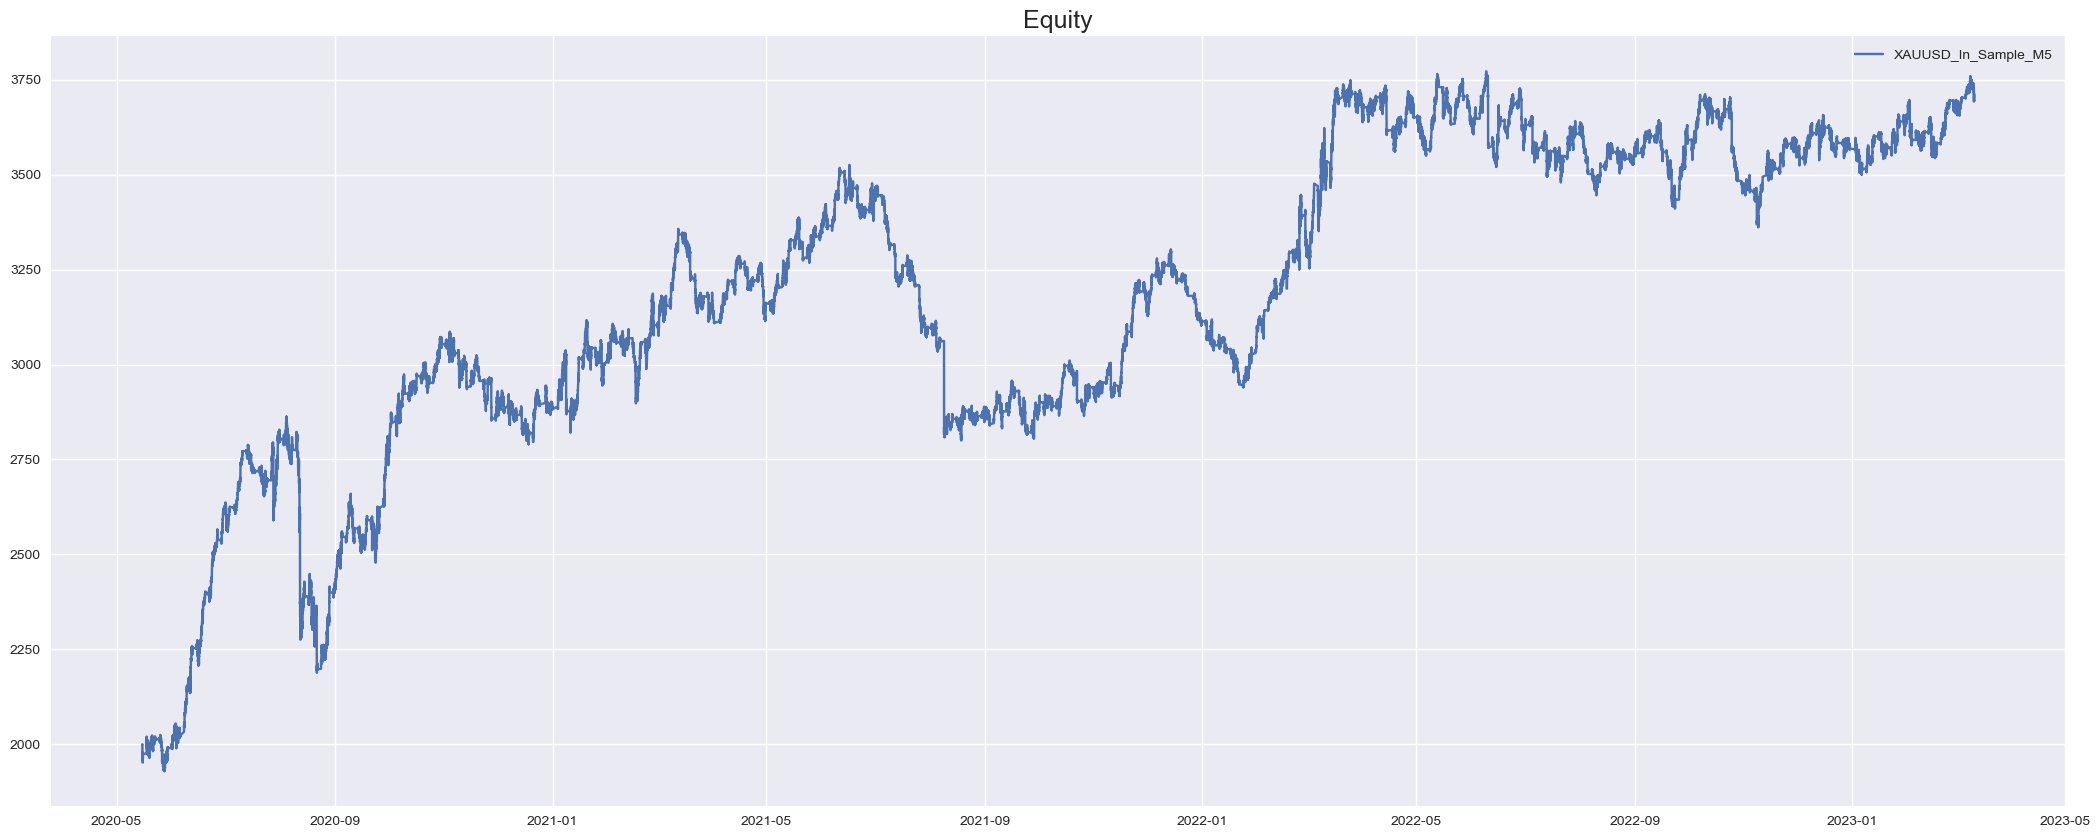

In [162]:
plot_equity_trades(train['_trades'], f'XAUUSD_In_Sample_{TF}' , account_size)

### Out-Sample Backtesting

In [163]:
test

Start                     2023-01-02 23:30:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:25:00
Exposure Time [%]                   99.985063
Equity Final [$]                     2112.246
Equity Peak [$]                      2177.558
Return [%]                             5.6123
Buy & Hold Return [%]                1.999557
Return (Ann.) [%]                   25.791125
Volatility (Ann.) [%]               27.254136
Sharpe Ratio                          0.94632
Sortino Ratio                        1.707518
Calmar Ratio                         3.533044
Max. Drawdown [%]                   -7.299973
Avg. Drawdown [%]                   -0.565981
Max. Drawdown Duration       27 days 08:25:00
Avg. Drawdown Duration        0 days 20:13:00
# Trades                                13388
Win Rate [%]                        51.740365
Best Trade [%]                       0.753041
Worst Trade [%]                     -1.404384
Avg. Trade [%]                    

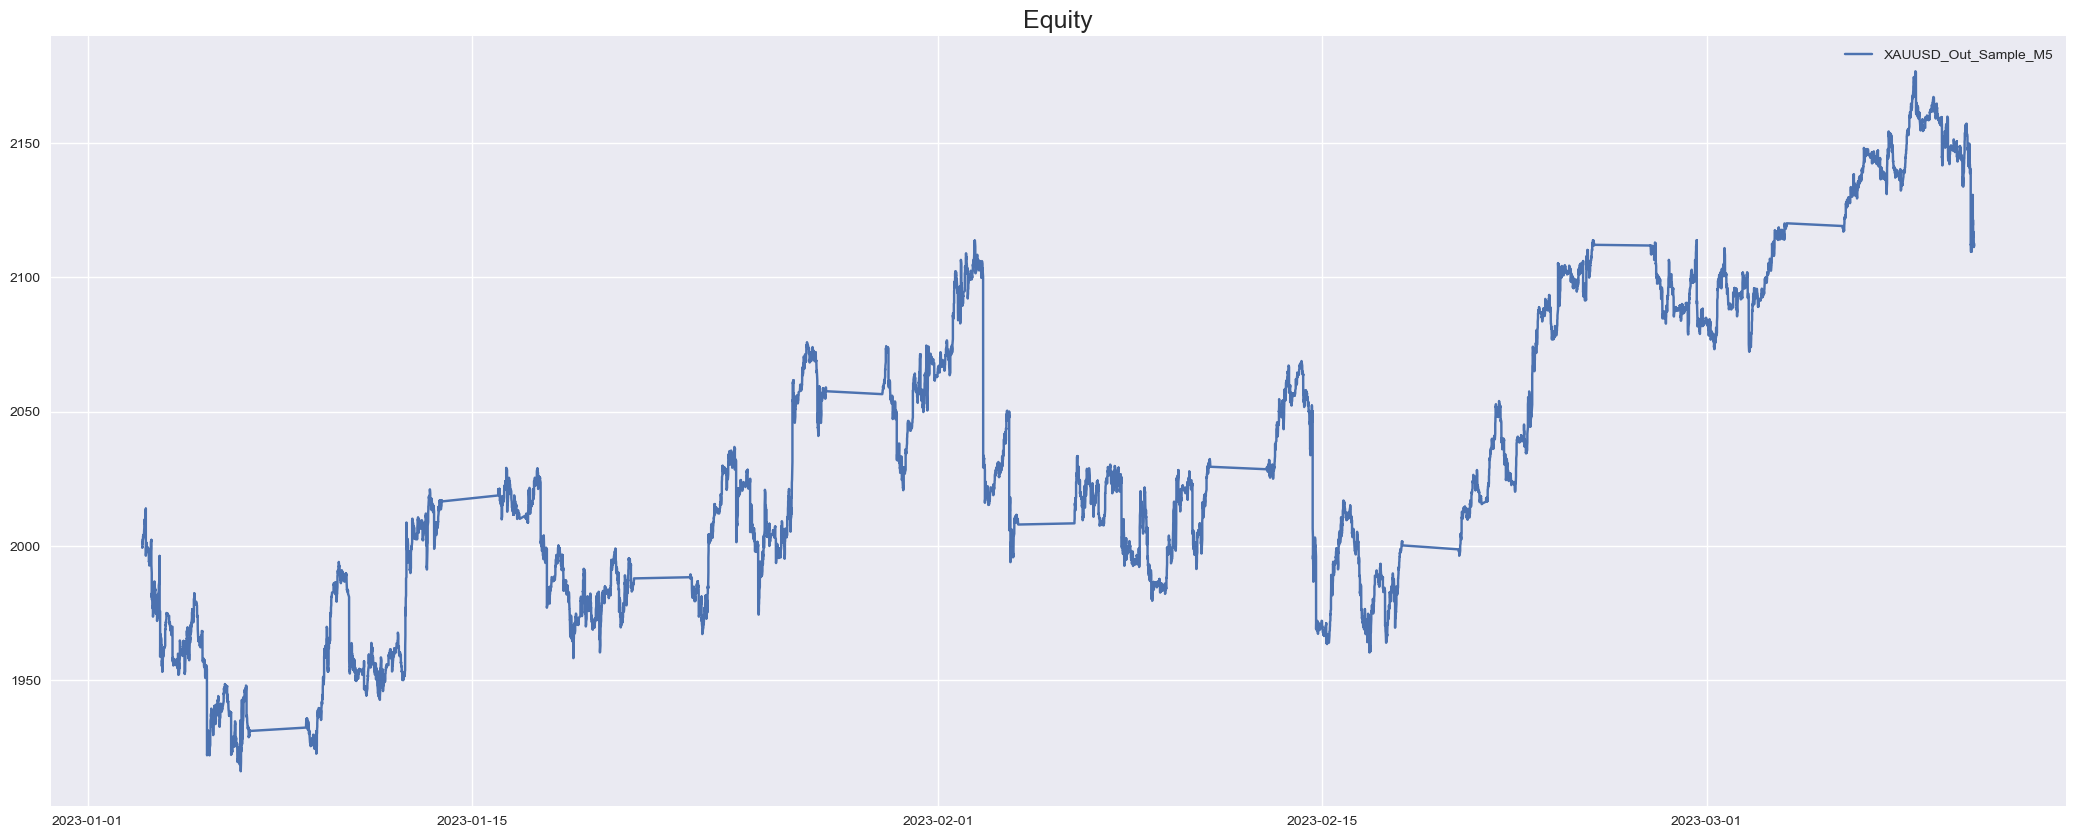

In [164]:
plot_equity_trades(test['_trades'], f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [165]:
filename_train = f'result_{TF}_In_Sample.csv'

In [166]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [167]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [168]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M1

In [169]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'

In [170]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [171]:
train , test = ml.Run()

### In-Sample Backtesting

In [172]:
train

Start                     2022-08-16 23:19:00
End                       2023-03-10 17:59:00
Duration                    205 days 18:40:00
Exposure Time [%]                      99.999
Equity Final [$]                     3786.824
Equity Peak [$]                      3874.294
Return [%]                            89.3412
Buy & Hold Return [%]                4.985419
Return (Ann.) [%]                  148.771544
Volatility (Ann.) [%]               72.108377
Sharpe Ratio                         2.063166
Sortino Ratio                        8.665565
Calmar Ratio                         6.952402
Max. Drawdown [%]                  -21.398583
Avg. Drawdown [%]                   -0.216303
Max. Drawdown Duration       83 days 23:41:00
Avg. Drawdown Duration        0 days 04:37:00
# Trades                               199992
Win Rate [%]                         53.01212
Best Trade [%]                       0.933864
Worst Trade [%]                     -1.117856
Avg. Trade [%]                    

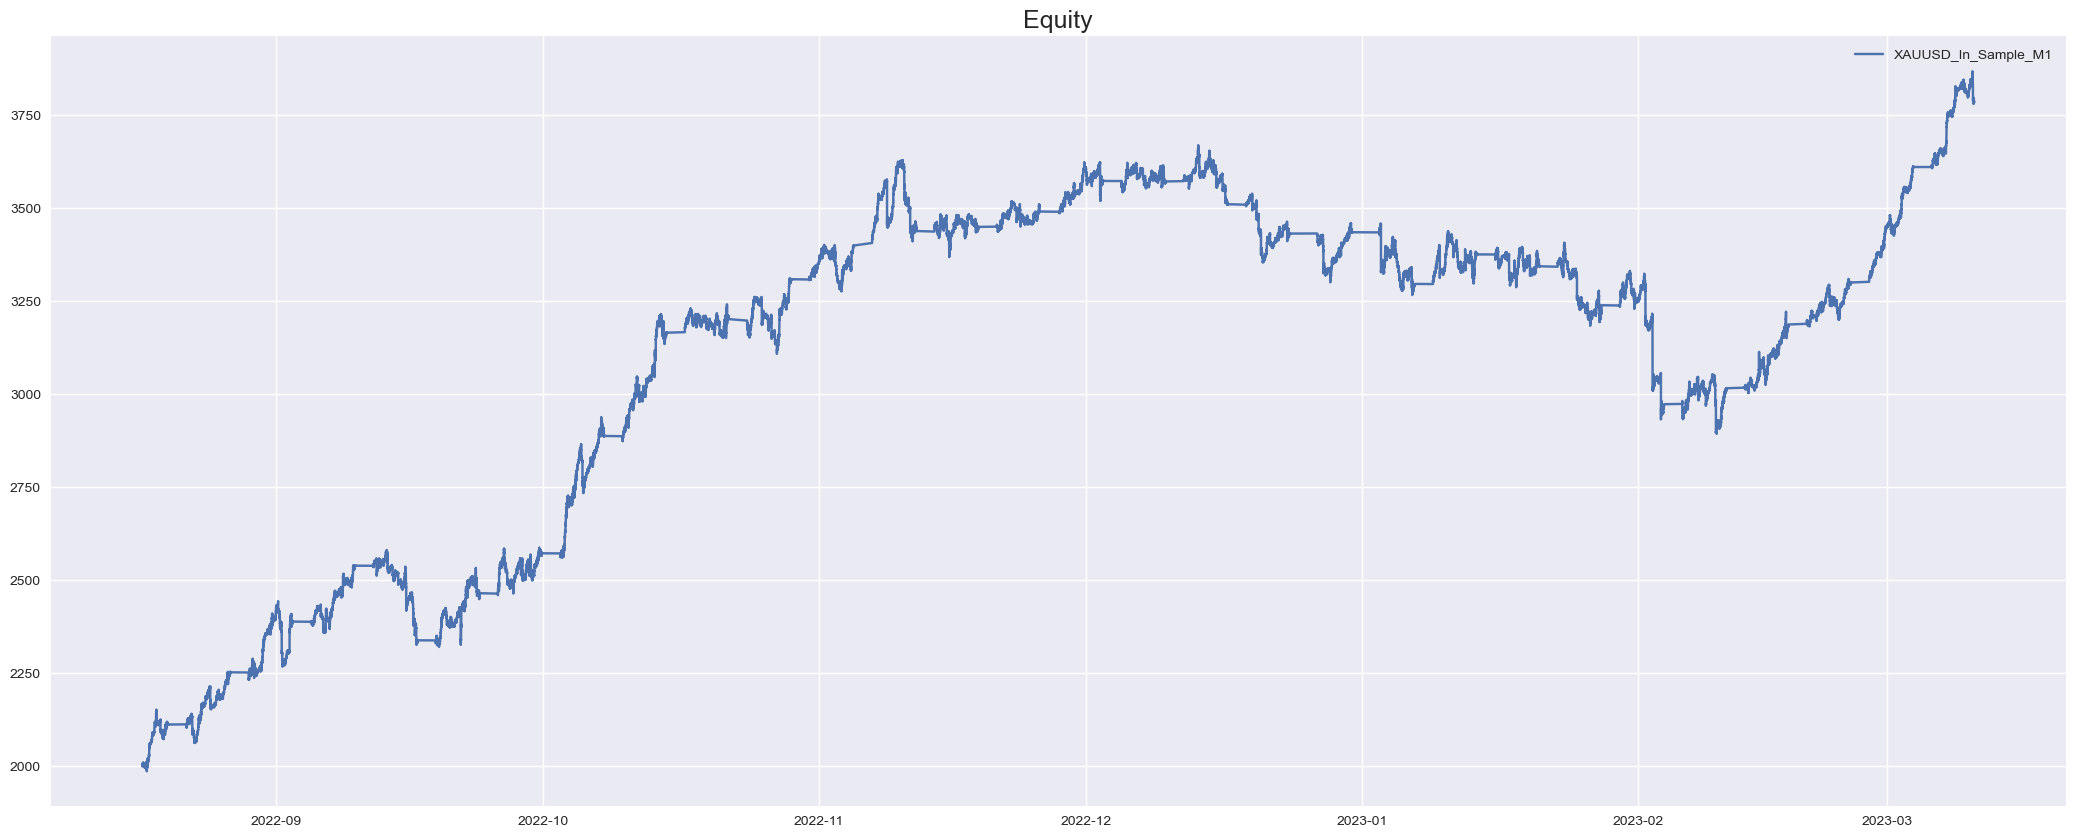

In [173]:
plot_equity_trades(train['_trades'], f'XAUUSD_In_Sample_{TF}' , account_size)

### Out-Sample Backtesting

In [174]:
test

Start                     2023-01-02 23:08:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:51:00
Exposure Time [%]                   99.997013
Equity Final [$]                       2345.6
Equity Peak [$]                       2433.07
Return [%]                              17.28
Buy & Hold Return [%]                1.903539
Return (Ann.) [%]                  102.164915
Volatility (Ann.) [%]               96.424183
Sharpe Ratio                         1.059536
Sortino Ratio                        3.242987
Calmar Ratio                         3.578027
Max. Drawdown [%]                  -28.553423
Avg. Drawdown [%]                   -0.297202
Max. Drawdown Duration       56 days 23:09:00
Avg. Drawdown Duration        0 days 06:09:00
# Trades                                66951
Win Rate [%]                        52.795328
Best Trade [%]                       0.708517
Worst Trade [%]                      -0.92513
Avg. Trade [%]                    

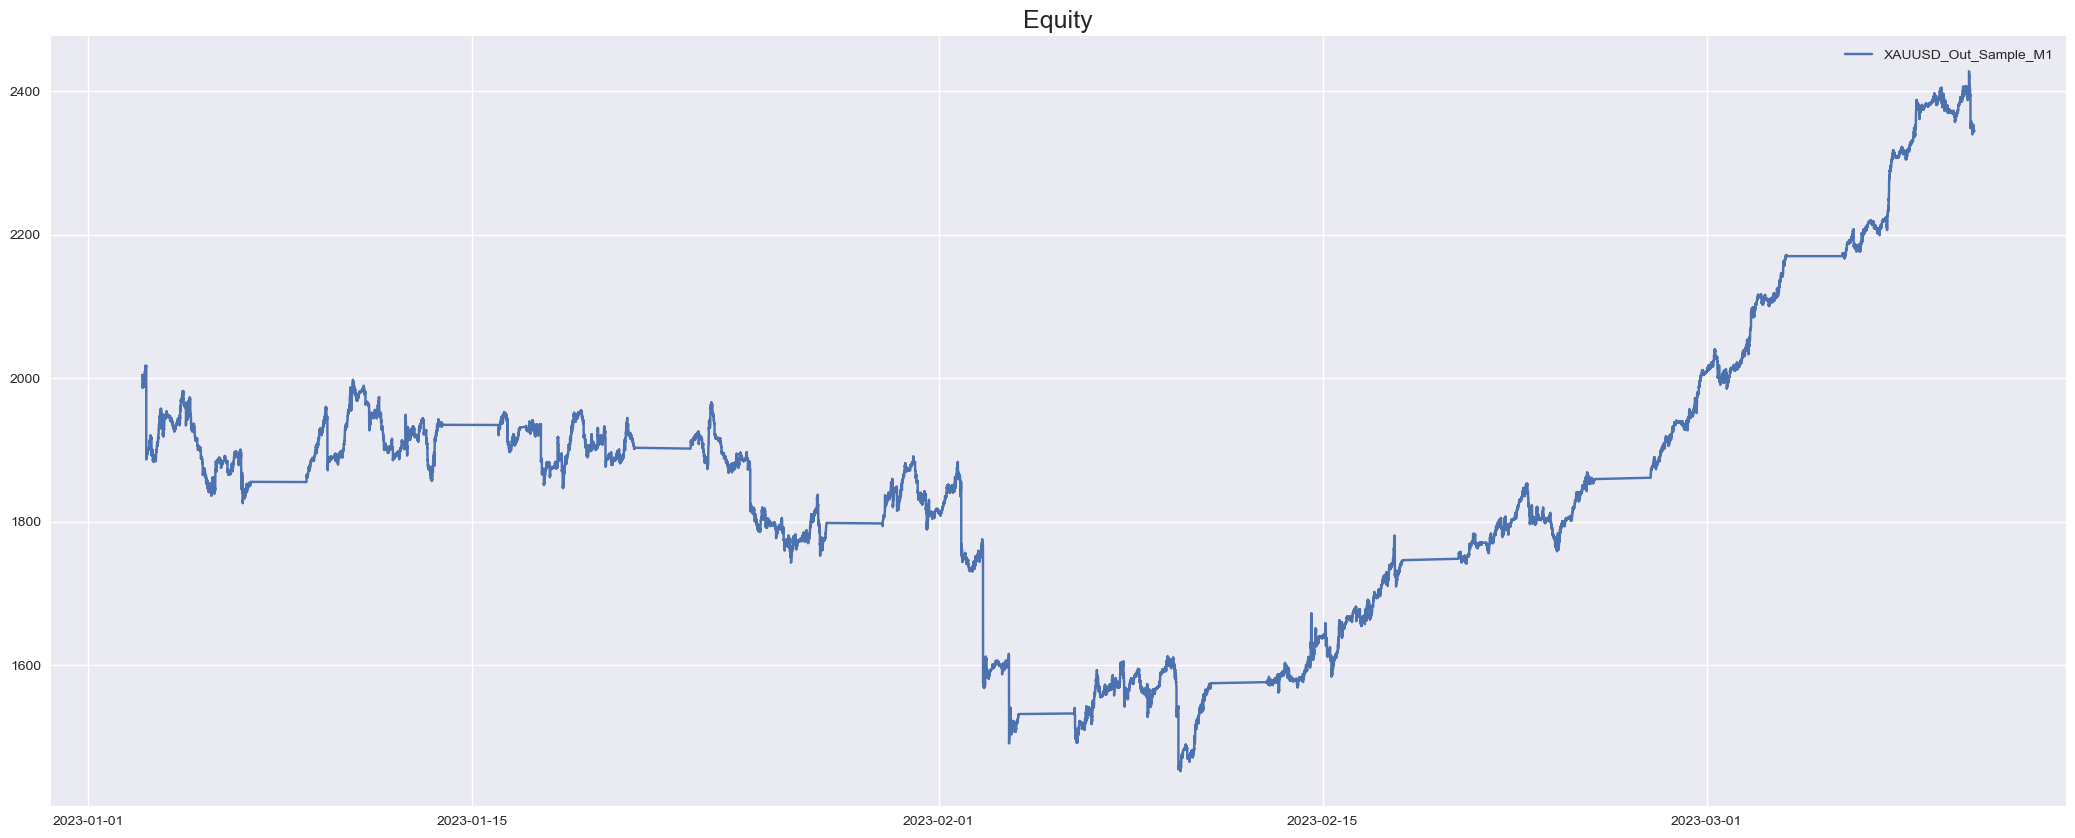

In [175]:
plot_equity_trades(test['_trades'], f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [176]:
filename_train = f'result_{TF}_In_Sample.csv'

In [177]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')